# Marshall Flow

In [1]:
#%% IMPORTS
#BASICS
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from numpy import absolute
from pandas.plotting import scatter_matrix
from sklearn.pipeline import make_pipeline
from IPython.display import display, Markdown, Latex
pd.options.display.max_columns = None

#STATISTICS
from scipy.stats import normaltest
from scipy import stats

#ML TRAINING AND DATA PREPROCESSING
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.preprocessing import PolynomialFeatures

#ML MODELS
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import BayesianRidge
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import SGDRegressor
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import ExtraTreesRegressor
from xgboost import XGBRegressor
import xgboost as xgb
from xgboost import plot_importance

#MODEL EVALUATION
from sklearn.model_selection import cross_validate
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV 
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import RepeatedKFold

#METRICS
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

## 1. Methods

In [2]:
#Eliminate Outliers based on the interquantile
#datFrame: Data frame where the outliers will be eliminated.
#columnName: the name of the column where the outliers will be identified.
def eliminateOutliers (dataFrame, columnName):
    Q1 = dataFrame[columnName].quantile(0.25)
    Q3 = dataFrame[columnName].quantile(0.75)
    IQR = Q3 - Q1
    print('Initial dataframe size: '+str(dataFrame.shape))
    dataFrame = dataFrame[(dataFrame[columnName] < (Q3 + 1.5 * IQR)) & (dataFrame[columnName] > (Q1 - 1.5 * IQR))]
    print('Final dataframe size: '+str(dataFrame.shape))
    return dataFrame

In [3]:
# Create the boxplot graphs for the categorical variables
# dataFrame: Data frame associated to the property of interest (dfAirVoids, dfMS, dfMF, dfITS, dfTSR)
# propertyOfInterest: the name of the column where the property of interest is located.
# columnName1...4: The categorical columns to evaluate.
def displayBoxPlotGraphs (dataFrame, propertyOfInterest, columnName1, columnName2, columnName3, columnName4):
    f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15,10))
    sns.boxplot(y = propertyOfInterest, x = columnName1, data=dataFrame,  orient='v' , ax=ax1)
    sns.boxplot(y = propertyOfInterest, x = columnName2, data=dataFrame,  orient='v' , ax=ax2)
    sns.boxplot(y = propertyOfInterest, x= columnName3, data=dataFrame,  orient='v' , ax=ax3)
    sns.boxplot(y= propertyOfInterest, x= columnName4, data=dataFrame,  orient='v' , ax=ax4)

In [4]:
#Method that print the best parameters, R2 and MSE based on a grid search.
def printBestModel (grid):
    mse = grid.best_score_
    print('Best Parameters:' , grid.best_params_)
    print('Best MSE:' + str(-mse))

## 2. Data Import

In [5]:
#%%DATA READING AND INITIAL PREPROCESSING
numericColumns = ['Aggregate absorption (%)',
                  'Apparent specific gravity',
                    0.075,
                    0.3,
                    0.6,
                    2.36,
                    4.75,
                    9.5,
                    12.5,
                    19,
                    'Plastic particle size (mm)',
                    'Mixing speed (RPM)',
                    'Mixing Temperature',
                    'Mixing Time (hours)',
                    'Plastic Addition by bitumen weight (%)',
                    'Bitumen content in the sample'
                    ]
categoricalColumns = ['Modified asphalt Mix?',
                      'Agreggate Type',
                    'Aggregate absorption (%)',
                    'Filler used',
                    'Consolidated bitumen penetration grade',
                    'New Plastic Type',
                    'Plastic pretreatment',
                    'Plastic shape',
                    'Plastic Size',
                    'Mixing Process',
                    'Plastic melted previous to addition?',
                    'Aggregates replacement ?',
                    'Bitumen replacement?',
                    'Filler replacement',
                    'Property',
                    'Units']
#It returns the dataframe of interes based on the property - 'AirVoids', 'MS', 'MF', 'ITS', 'TSR'
def returnDf (propertyOfInterest):
    df = pd.read_excel('fileML.xlsx', sheet_name = propertyOfInterest, engine='openpyxl')
    df = df.set_index(propertyOfInterest + ' ID')
    df.loc[:,:'Units'] = df.loc[:,:'Units'].applymap(str)
    df.loc[:,:'Units'] = df.loc[:,:'Units'] .applymap(str.strip)
    df.replace('NS', np.nan, inplace = True)
    df[numericColumns] = df[numericColumns].replace('N/a', 0).astype(float)
    return df

In [6]:
dfMF = returnDf('MF')

## 3. Data Exploration
###  3.1 Total Sample

In [7]:
dfMF = eliminateOutliers(dfMF, 'MF of the sample [mm]')

Initial dataframe size: (316, 34)
Final dataframe size: (296, 34)


In [8]:
dfMF.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 296 entries, 1 to 316
Data columns (total 34 columns):
 #   Column                                  Non-Null Count  Dtype  
---  ------                                  --------------  -----  
 0   Article ID                              296 non-null    object 
 1   Global ID                               296 non-null    object 
 2   Modified asphalt Mix?                   296 non-null    object 
 3   Agreggate Type                          149 non-null    object 
 4   Aggregate absorption (%)                176 non-null    float64
 5   Apparent specific gravity               88 non-null     float64
 6   0.075                                   218 non-null    float64
 7   0.3                                     266 non-null    float64
 8   0.6                                     235 non-null    float64
 9   2.36                                    246 non-null    float64
 10  4.75                                    266 non-null    float6

In [9]:
dfMF.iloc[:,2:].describe(include = "all")

,Modified asphalt Mix?,Agreggate Type,Aggregate absorption (%),Apparent specific gravity,0.075,0.3,0.6,2.36,4.75,9.5,12.5,19,Filler used,Bitumen Type Penetration Grade,Consolidated bitumen penetration grade,New Plastic Type,Plastic pretreatment,Plastic shape,Plastic Size,Plastic particle size (mm),Mixing Process,Mixing speed (RPM),Mixing Temperature,Mixing Time (hours),Aggregates replacement ?,Bitumen replacement?,Filler replacement,Plastic Addition by bitumen weight (%),Property,Units,Bitumen content in the sample,MF of the sample [mm]
count,296,149,176.000000,88.000000,218.000000,266.000000,235.000000,246.000000,266.000000,235.000000,251.000000,266.00000,136,296,296,271,296,296,222,209.000000,296,267.000000,280.000000,267.000000,296,296,296,294.000000,296,296,293.000000,296.000000
unique,2,6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4,5,3,10,3,4,4,NaN,3,NaN,NaN,NaN,2,2,2,NaN,1,1,NaN,NaN
top,Yes,Granite,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Stone dust,50/70,50/70,N/a,Physical,Shredded,Fine,NaN,Dry,NaN,NaN,NaN,No,No,No,NaN,MF,mm,NaN,NaN
freq,223,76,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,82,121,214,73,212,190,123,NaN,180,NaN,NaN,NaN,280,273,294,NaN,296,296,NaN,NaN
mean,NaN,NaN,0.997244,2.673068,7.120275,16.434098,22.695277,39.547561,50.989211,71.564213,84.311394,94.45797,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.221153,NaN,82.022472,17.857143,0.055618,NaN,NaN,NaN,23.592279,NaN,NaN,5.319396,3.420992
std,NaN,NaN,0.864318,0.068539,6.345598,5.793486,6.896635,8.134936,9.562091,13.038299,11.965428,6.71736,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7.091503,NaN,480.204796,56.553153,0.274352,NaN,NaN,NaN,52.312923,NaN,NaN,0.924330,0.807007
min,NaN,NaN,0.130000,2.590000,2.190000,5.300000,9.000000,20.000000,24.000000,47.000000,66.840000,83.32000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,NaN,0.000000,0.000000,0.000000,NaN,NaN,NaN,0.000000,NaN,NaN,2.500000,1.640000
25%,NaN,NaN,0.130000,2.600000,5.000000,12.617500,18.900000,35.370000,46.150000,60.510000,78.000000,89.22000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,NaN,0.000000,0.000000,0.000000,NaN,NaN,NaN,0.625000,NaN,NaN,5.000000,2.890000
50%,NaN,NaN,0.800000,2.660000,5.280000,14.470000,20.800000,36.260000,50.130000,70.490000,85.000000,99.01500,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.360000,NaN,0.000000,0.000000,0.000000,NaN,NaN,NaN,6.076923,NaN,NaN,5.250000,3.300000
75%,NaN,NaN,1.020000,2.725000,7.000000,20.000000,23.110000,46.150000,54.770000,79.000000,95.000000,100.00000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.750000,NaN,0.000000,0.000000,0.000000,NaN,NaN,NaN,13.000000,NaN,NaN,6.000000,3.800000


The mean of the MF observations is 3.42, with and standard deviation of 0.8. In the Australian standards, the MF usually is between 2 and 5.

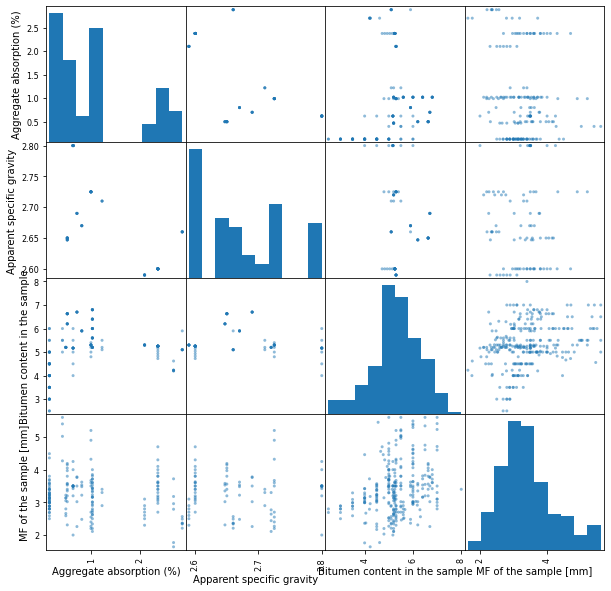

In [10]:
scatter_matrix(dfMF[['Aggregate absorption (%)', 'Apparent specific gravity', 'Bitumen content in the sample', 'MF of the sample [mm]']], figsize=(10, 10))
plt.show()

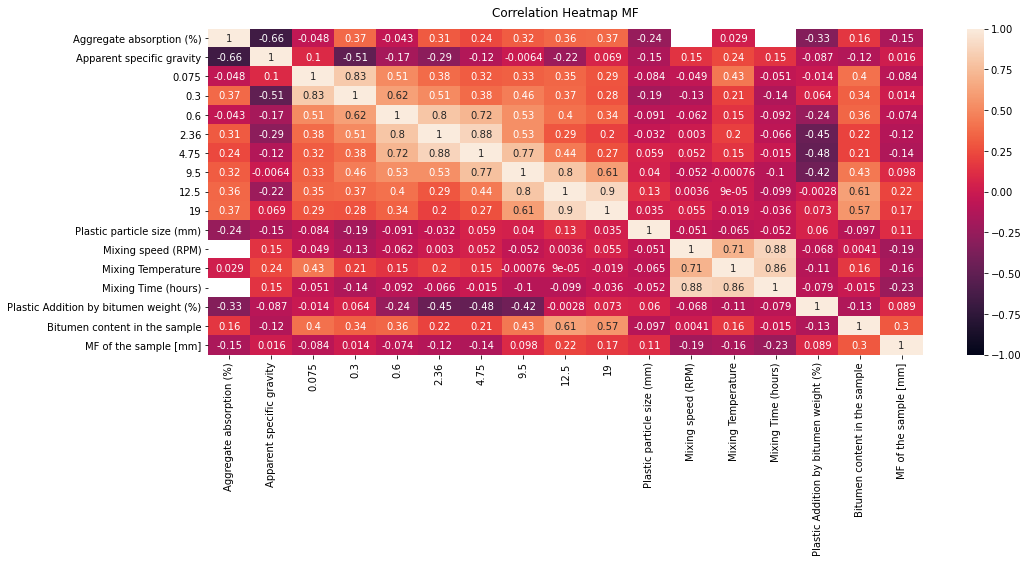

In [11]:
plt.figure(figsize=(16, 6))
heatmap = sns.heatmap(dfMF.corr(), vmin=-1, vmax=1, annot=True)
heatmap.set_title('Correlation Heatmap MF', fontdict={'fontsize':12}, pad=12);

The strongest correlation of MF is with the $\color{red}{\text{bitumen content}}$ in the sample.

In [ ]:
displayBoxPlotGraphs(dataFrame = dfMF, propertyOfInterest = 'MF of the sample [mm]', columnName1 = "Agreggate Type", columnName2 = "Filler used", columnName3 = "Consolidated bitumen penetration grade", columnName4 = "Modified asphalt Mix?")

The $\color{red}{\text{bitumen type}}$ has similar MF, and it happens the same among the samples $\color{red}{\text{with and without}}$ plastic modification.
###  3.2 Modified mixtures

In [ ]:
dfMFModvsUnmod = dfMF [['Modified asphalt Mix?', 'MF of the sample [mm]']]
dfMFModvsUnmod.groupby(['Modified asphalt Mix?'], as_index=False).describe()

In [ ]:
dfMFModified = dfMF[dfMF['Modified asphalt Mix?'] == 'Yes']
dfMFModified.iloc[:,2:].describe(include = "all")

In [ ]:
columnsOfInteres = numericColumns[0:2]+numericColumns[10:]+['MF of the sample [mm]']
scatter_matrix(dfMFModified[columnsOfInteres], figsize=(25, 20))
plt.show()

In [ ]:
plt.figure(figsize=(16, 6))
heatmap = sns.heatmap(dfMFModified.corr(), vmin=-1, vmax=1, annot=True)
heatmap.set_title('Correlation Heatmap MF', fontdict={'fontsize':12}, pad=12)

Again, in the modified mixtures, the largest positive correlation is with $\color{red}{\text{bitumen content}}$. By looking the graph, one might expect a large correlation with $\color{red}{\text{plastic addition}}$, but this is not the case because many observations were skewed to the left.

In [ ]:
displayBoxPlotGraphs(dataFrame = dfMFModified, propertyOfInterest = "MF of the sample [mm]", columnName1 = "Agreggate Type", columnName2 = "Plastic shape", columnName3 = "New Plastic Type", columnName4 = "Mixing Process")

No significant difference between dry and wet.
###  3.3 Wet vs. Dry Mixing

In [ ]:
dfMFWetvsDry = dfMFModified [['Mixing Process', 'MF of the sample [mm]']]
dfMFWetvsDry.groupby(['Mixing Process'], as_index=False).describe()

In [ ]:
sns.pairplot(dfMFModified[columnsOfInteres+['Mixing Process']], hue="Mixing Process", height=2.5)

##  **Marshall Flow summary:**

 *  20 outliers were eliminated from the original sample.
 *  Total number of observation: 296 -> $\mu$ = 3.42, $\sigma$ = 0.8
 *  $\color{red}{\text{Agregate absorption}}$ has a high number of missing values; 40 percent of the data points. Nevertheless, it is still an important value according to the Pearson correlation value (r = -0.15)
 *  The variable with the largest positive correlation is $\color{red}{\text{bitumen content}}$ (r = 0.3). It makes sense as higher quantities of bitumen will increase the cohesion of aggregates in the asphalt mixture.
 *  Not much difference between the modified and unmodified mixtures -> $\mu_{modified}$ = 3.44, $\sigma_{modified}$ = 0.8
 *  Modified mixtures present positive correlation with $\color{red}{\text{bitumen content}}$ (r = 0.33), and negative correlation with mixing properties; $\color{red}{\text{shear}}$ (r = -0.24), $\color{red}{\text{temperature}}$ (r = -0.2) and $\color{red}{\text{mixing time}}$ (r = -0.28).
 *  Not significan difference between dry and wet. Dry has 180 observations ($\mu_{dry}$ = 3.49, $\sigma_{dry}$ = 0.79) while wet has 43 observations ($\mu_{wet}$ = 3.24, $\sigma_{wet}$ = 0.81)


## 4. Data Pre-processing

In [8]:
dfMF.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 296 entries, 1 to 316
Data columns (total 34 columns):
 #   Column                                  Non-Null Count  Dtype  
---  ------                                  --------------  -----  
 0   Article ID                              296 non-null    object 
 1   Global ID                               296 non-null    object 
 2   Modified asphalt Mix?                   296 non-null    object 
 3   Agreggate Type                          149 non-null    object 
 4   Aggregate absorption (%)                176 non-null    float64
 5   Apparent specific gravity               88 non-null     float64
 6   0.075                                   218 non-null    float64
 7   0.3                                     266 non-null    float64
 8   0.6                                     235 non-null    float64
 9   2.36                                    246 non-null    float64
 10  4.75                                    266 non-null    float6

###  Pre-processing:
1.  Eliminate the columns $\color{red}{\text{Article ID}}$, $\color{red}{\text{Global ID}}$, $\color{red}{\text{Aggregate type}}$, $\color{red}{\text{Apparent specific gravity}}$, $\color{red}{\text{filler used}}$, $\color{red}{\text{Bitumen type penetration grade}}$, $\color{red}{\text{plastic size}}$, $\color{red}{\text{Property}}$ and $\color{red}{\text{Units}}$.
2.  Change the N/a to zero. This is for the unmodified mixtures.
3.  Eliminate rows with missing values in $\color{red}{\text{New Plastic Type}}$, $\color{red}{\text{Plastic addition by bitumen weight}}$ and $\color{red}{\text{bitumen content in sample}}$.
4.  Change categorical columns to numeric - $\color{red}{\text{Modified asphalt Mix?}}$, $\color{red}{\text{Consolidated bitumen penetration grade}}$, $\color{red}{\text{New Plastic Type}}$, $\color{red}{\text{Plastic pretreatment}}$, $\color{red}{\text{Plastic shape}}$, $\color{red}{\text{Mixing Process}}$, $\color{red}{\text{Plastic melted previous to addition?}}$, $\color{red}{\text{Replacements}}$.
5.  Imputer to $\color{red}{\text{Aggregate absorption}}$, $\color{red}{\text{gradation}}$, $\color{red}{\text{plastic size(mm)}}$, and $\color{red}{\text{mixing parameters}}$.

In [9]:
#Categorical Variables
dfMFCleaned = dfMF.drop(['Article ID', 
                        'Global ID',
                        'Agreggate Type',
                        'Modified asphalt Mix?', 
                        'Apparent specific gravity', 
                        'Filler used', 
                        'Bitumen Type Penetration Grade',
                        'Plastic Size', 
                        'Property', 
                        'Units'], axis = 1)
dfMFCleaned = dfMFCleaned.replace('N/a', 0)
dfMFCleaned = dfMFCleaned.dropna(subset=['New Plastic Type', 
                                        'Plastic Addition by bitumen weight (%)', 
                                        'Bitumen content in the sample'])
dfMFCleaned = pd.get_dummies(dfMFCleaned, columns=['New Plastic Type'], drop_first = False)
dfMFCleaned = pd.get_dummies(dfMFCleaned, drop_first=True)
dfMFCleaned = dfMFCleaned.drop(['New Plastic Type_0'], axis = 1)
dfMFCleaned.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 268 entries, 1 to 316
Data columns (total 36 columns):
 #   Column                                         Non-Null Count  Dtype  
---  ------                                         --------------  -----  
 0   Aggregate absorption (%)                       151 non-null    float64
 1   0.075                                          215 non-null    float64
 2   0.3                                            263 non-null    float64
 3   0.6                                            232 non-null    float64
 4   2.36                                           243 non-null    float64
 5   4.75                                           263 non-null    float64
 6   9.5                                            232 non-null    float64
 7   12.5                                           248 non-null    float64
 8   19                                             263 non-null    float64
 9   Plastic particle size (mm)                     206 non

In [10]:
#IMPUTATION OF MISSING VALUES
imputer = IterativeImputer (estimator = ExtraTreesRegressor(n_estimators=10, random_state=123), max_iter=100)
n = imputer.fit_transform(dfMFCleaned)
dfMFCleanedImputed = pd.DataFrame(n, columns = list(dfMFCleaned.columns))
dfMFCleanedImputed.info()
print ('There is '+str(sum(n < 0 for n in dfMFCleanedImputed.values.flatten()))+' negative values in the new Dataframe')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 268 entries, 0 to 267
Data columns (total 36 columns):
 #   Column                                         Non-Null Count  Dtype  
---  ------                                         --------------  -----  
 0   Aggregate absorption (%)                       268 non-null    float64
 1   0.075                                          268 non-null    float64
 2   0.3                                            268 non-null    float64
 3   0.6                                            268 non-null    float64
 4   2.36                                           268 non-null    float64
 5   4.75                                           268 non-null    float64
 6   9.5                                            268 non-null    float64
 7   12.5                                           268 non-null    float64
 8   19                                             268 non-null    float64
 9   Plastic particle size (mm)                     268 non

In [11]:
dfMFCleanedImputed['New Plastic Type_Nylon'] = dfMFCleanedImputed['New Plastic Type_Nylon'] * dfMFCleanedImputed['Plastic Addition by bitumen weight (%)']
dfMFCleanedImputed['New Plastic Type_PE'] = dfMFCleanedImputed['New Plastic Type_PE'] * dfMFCleanedImputed['Plastic Addition by bitumen weight (%)']
dfMFCleanedImputed['New Plastic Type_PET'] = dfMFCleanedImputed['New Plastic Type_PET'] * dfMFCleanedImputed['Plastic Addition by bitumen weight (%)']
dfMFCleanedImputed['New Plastic Type_PP'] = dfMFCleanedImputed['New Plastic Type_PP'] * dfMFCleanedImputed['Plastic Addition by bitumen weight (%)']
dfMFCleanedImputed['New Plastic Type_PS'] = dfMFCleanedImputed['New Plastic Type_PS'] * dfMFCleanedImputed['Plastic Addition by bitumen weight (%)']
dfMFCleanedImputed['New Plastic Type_PU'] = dfMFCleanedImputed['New Plastic Type_PU'] * dfMFCleanedImputed['Plastic Addition by bitumen weight (%)']
dfMFCleanedImputed['New Plastic Type_PVC'] = dfMFCleanedImputed['New Plastic Type_PVC'] * dfMFCleanedImputed['Plastic Addition by bitumen weight (%)']
dfMFCleanedImputed['New Plastic Type_Plastic Mix'] = dfMFCleanedImputed['New Plastic Type_Plastic Mix'] * dfMFCleanedImputed['Plastic Addition by bitumen weight (%)']
dfMFCleanedImputed['New Plastic Type_e-waste'] = dfMFCleanedImputed['New Plastic Type_e-waste'] * dfMFCleanedImputed['Plastic Addition by bitumen weight (%)']
dfMFCleanedImputed = dfMFCleanedImputed.drop(['Plastic Addition by bitumen weight (%)'], axis = 1)

In [12]:
scaler = MinMaxScaler()
dfMFCleanedImputedScaled = pd.DataFrame(scaler.fit_transform(dfMFCleanedImputed), columns = list(dfMFCleanedImputed.columns))
dfMFCleanedImputedScaled.to_clipboard()

## 5. Model Training

In [13]:
X = dfMFCleanedImputedScaled.loc[:, dfMFCleanedImputedScaled.columns != 'MF of the sample [mm]']
y = dfMFCleanedImputedScaled.loc[:,'MF of the sample [mm]']
cv = RepeatedKFold(n_splits = 5, n_repeats = 10, random_state = 123)

### 5.1 Model Evaluation
#### Linear Model

In [14]:
param_grid = {'fit_intercept': [True, False],
            'positive': [True, False]}
grid = GridSearchCV(LinearRegression(), param_grid, cv=cv, scoring=['r2','neg_mean_squared_error'], refit = 'neg_mean_squared_error', return_train_score= True)
grid.fit(X, y)
printBestModel(grid)

Best Parameters: {'fit_intercept': False, 'positive': False}
Best MSE:0.03286191869032953


#### Lasso Linear Model

In [60]:
param_grid = {'alpha': [0.001,1,2, 10, 15, 30, 50, 100],
            'fit_intercept':[True, False],
            'positive': [True, False]}
grid = GridSearchCV(Lasso(), param_grid, cv=cv, scoring=['r2','neg_mean_squared_error'], refit = 'neg_mean_squared_error', return_train_score= True)
grid.fit(X, y)
printBestModel(grid)

Best Parameters: {'alpha': 0.001, 'fit_intercept': True, 'positive': False}
Best MSE:0.00784983981811924


#### Ridge Linear Regression Model

In [48]:
param_grid = {'alpha': [0,5,15,100],
'fit_intercept': [True, False],
'solver': [ 'svd', 'cholesky', 'lsqr', 'sparse_cg', 'sag', 'saga']}
grid = GridSearchCV(Ridge(), param_grid, cv=cv, scoring=['r2','neg_mean_squared_error'], refit = 'neg_mean_squared_error')
grid.fit(X, y)
printBestModel(grid)

C:\Users\cavs1\Anaconda3\envs\spyder\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=8.05817e-17): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,
C:\Users\cavs1\Anaconda3\envs\spyder\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=1.57612e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,
C:\Users\cavs1\Anaconda3\envs\spyder\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=7.56485e-17): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,
C:\Users\cavs1\Anaconda3\envs\spyder\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=1.01357e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,
C:\Users\cavs1\Anaconda3\envs\spyder\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-condit

#### Linear elastic Net

In [49]:
param_grid = {'alpha': [0.01,1,2,3,4],
'fit_intercept': [True, False]}
grid = GridSearchCV(ElasticNet(), param_grid, cv=cv, scoring=['r2','neg_mean_squared_error'], refit = 'neg_mean_squared_error')
grid.fit(X, y)
printBestModel(grid)

Best Parameters: {'alpha': 0.01, 'fit_intercept': True}
Best MSE:0.012719729197107111


#### Polynomial model

In [50]:
def PolynomialRegression(degree=2, **kwargs):
    return make_pipeline(PolynomialFeatures(degree), Ridge(**kwargs))

param_grid = {'polynomialfeatures__degree': [2,3],
'ridge__alpha':[10, 20,30,50],
'ridge__fit_intercept': [True, False],
'ridge__solver': [ 'lsqr', 'cholesky', 'sparse_cg', 'svd', 'sag']}
grid = GridSearchCV(PolynomialRegression(), param_grid, cv=cv, scoring=['r2','neg_mean_squared_error'], refit='neg_mean_squared_error')
grid.fit(X, y)
printBestModel(grid)

KeyboardInterrupt: 

#### Lasso polynomial model

In [ ]:
def PolynomialRegression(degree=2, **kwargs):
    return make_pipeline(PolynomialFeatures(degree), Lasso(**kwargs))

param_grid = {'polynomialfeatures__degree': [2,3,4],
            'lasso__alpha': [1, 10, 15, 30, 50, 100],
            'lasso__fit_intercept':[True, False],
            'lasso__positive': [True, False],
            'lasso__max_iter': [3000]}
grid = GridSearchCV(PolynomialRegression(), param_grid, cv=cv, scoring=['r2','neg_mean_squared_error'], refit = 'neg_mean_squared_error', return_train_score= True)
grid.fit(X, y)
printBestModel(grid)

#### Ridge Polynomial Model

In [ ]:
def PolynomialRegression(degree=2, **kwargs):
    return make_pipeline(PolynomialFeatures(degree), Ridge(**kwargs))

param_grid = {'polynomialfeatures__degree': [3,4],
'ridge__alpha':[10, 20,30,50],
'ridge__fit_intercept': [True, False],
'ridge__solver': [ 'lsqr', 'cholesky', 'sparse_cg', 'svd', 'sag']}
grid = GridSearchCV(PolynomialRegression(), param_grid, cv=cv, scoring=['r2','neg_mean_squared_error'], refit='neg_mean_squared_error'')
grid.fit(X, y)
printBestModel(grid)

#### Support Vector Regression

In [51]:
param_grid = {
    'kernel':['linear','rbf', 'sigmoid','poly'],
    'degree':[2,3],
    'C':[0.01,1,5,10],
    'epsilon':[0.1,0.5, 1, 1.5]
}
grid = GridSearchCV(SVR(), param_grid, cv=cv, scoring=['r2','neg_mean_squared_error'], refit='neg_mean_squared_error')
grid.fit(X, y)
printBestModel(grid)

Best Parameters: {'C': 1, 'degree': 2, 'epsilon': 0.1, 'kernel': 'poly'}
Best MSE:0.006394756507273431


#### Decision tree regresor

In [52]:
param_grid = {
    'max_depth':[None,2,3,5,10],
    'min_samples_split':[2,3,4],
    'min_samples_leaf':[1,2,5],
    'max_leaf_nodes': [None, 5,10]
}
grid = GridSearchCV(DecisionTreeRegressor(), param_grid, cv=cv, scoring=['r2','neg_mean_squared_error'], refit='neg_mean_squared_error')
grid.fit(X, y)
printBestModel(grid)

Best Parameters: {'max_depth': None, 'max_leaf_nodes': None, 'min_samples_leaf': 1, 'min_samples_split': 2}
Best MSE:0.0044770907286433995


#### Random Forest

In [ ]:
param_grid = {
    'bootstrap': [True, False],
    'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, None],
    'max_features': ['auto', 'sqrt'],
    'min_samples_leaf': [1, 2, 4],
    'min_samples_split': [2, 5, 10],
    'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000]
}
grid = RandomizedSearchCV(RandomForestRegressor(), param_grid, cv=cv, scoring=['r2','neg_mean_squared_error'], refit='neg_mean_squared_error', n_iter=100)
grid.fit(X, y)
printBestModel(grid)

#### Extra tree regressor

In [ ]:
param_grid = {
    'bootstrap': [True, False],
    'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, None],
    'max_features': ['auto', 'sqrt'],
    'min_samples_leaf': [1, 2, 4],
    'min_samples_split': [2, 5, 10],
    'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000]
}
grid = RandomizedSearchCV(ExtraTreesRegressor(), param_grid, cv=cv, scoring=['r2','neg_mean_squared_error'], refit='neg_mean_squared_error', n_iter=100)
grid.fit(X, y)
printBestModel(grid)

#### XG Boost Regressor

In [14]:
XGBoostModel = XGBRegressor()
scores = cross_val_score(XGBoostModel, X, y , scoring = 'neg_mean_squared_error', cv = cv)
scores = np.absolute(scores)
print (scores.mean())

0.01377697686114566


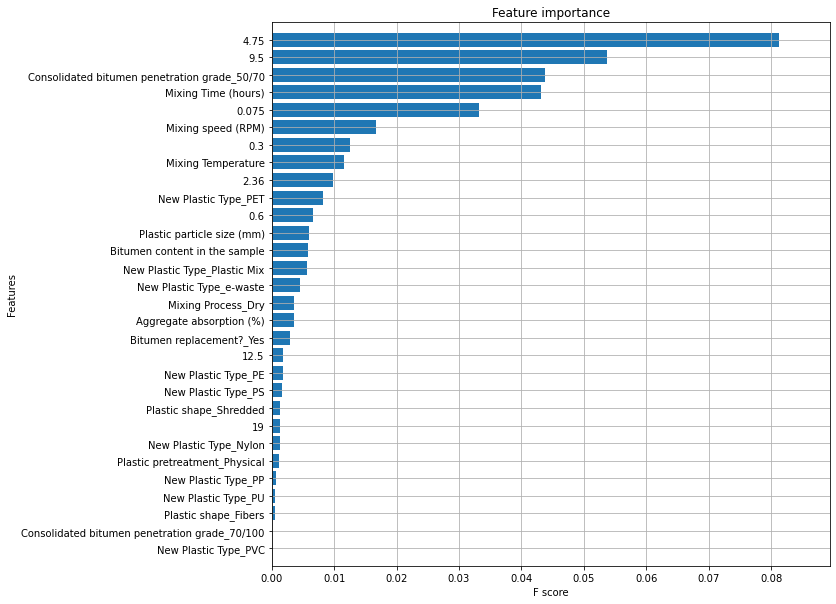

In [15]:
#Graph employed for selecting important features during tunning
XGBoostModel.fit(X,y)
ax = plot_importance(XGBoostModel, height=0.8, importance_type='gain', show_values=False)
fig = ax.figure
fig.set_size_inches(10,10)

## 6. Best Model Tunning

In [16]:
X.columns = X.columns.astype(str)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)
cv = RepeatedKFold(n_splits = 5, n_repeats = 15, random_state = 123)

### 6.1. Feature selection

In [33]:
features_MSE = {}
def addMSE (columns, string):
    cv_results = cross_validate(XGBRegressor(random_state = 1), X_train[columns], y_train, cv = cv, scoring = ['neg_mean_squared_error'])
    MSE = np.average(-cv_results['test_neg_mean_squared_error'])
    features_MSE[string] = MSE

In [34]:
X_train.columns

Index(['Aggregate absorption (%)', '0.075', '0.3', '0.6', '2.36', '4.75',
       '9.5', '12.5', '19', 'Plastic particle size (mm)', 'Mixing speed (RPM)',
       'Mixing Temperature', 'Mixing Time (hours)',
       'Bitumen content in the sample', 'New Plastic Type_Nylon',
       'New Plastic Type_PE', 'New Plastic Type_PET', 'New Plastic Type_PP',
       'New Plastic Type_PS', 'New Plastic Type_PU', 'New Plastic Type_PVC',
       'New Plastic Type_Plastic Mix', 'New Plastic Type_e-waste',
       'Consolidated bitumen penetration grade_50/70',
       'Consolidated bitumen penetration grade_70/100',
       'Plastic pretreatment_Physical', 'Plastic pretreatment_Plastic Melted',
       'Plastic shape_Fibers', 'Plastic shape_Pellets',
       'Plastic shape_Shredded', 'Mixing Process_Dry', 'Mixing Process_Wet',
       'Aggregates replacement ?_Yes', 'Bitumen replacement?_Yes'],
      dtype='object')

In [35]:
addMSE(['0.075', '0.3', '0.6', '2.36', '4.75','9.5', '12.5', '19'], 
'Gradation')

In [36]:
addMSE(['0.075', '0.3', '0.6', '2.36', '4.75','9.5', '12.5', '19',
        'Consolidated bitumen penetration grade_50/70', 'Consolidated bitumen penetration grade_70/100', 
        'Mixing Time (hours)'], 
'Gradation\n Bitumen type \n Mixing Time')

In [37]:
addMSE(['0.075', '0.3', '0.6', '2.36', '4.75','9.5', '12.5', '19',
        'Consolidated bitumen penetration grade_50/70', 'Consolidated bitumen penetration grade_70/100', 
        'Mixing Time (hours)', 
        'Mixing speed (RPM)'], 
'Gradation\n Bitumen type \n Mixing Time \n Mixing speed')

In [38]:
addMSE(['0.075', '0.3', '0.6', '2.36', '4.75','9.5', '12.5', '19',
        'Consolidated bitumen penetration grade_50/70', 'Consolidated bitumen penetration grade_70/100', 
        'Mixing Time (hours)', 
        'Mixing speed (RPM)',
        'Mixing Temperature'], 
'Gradation\n Bitumen type \n Mixing Time \n Mixing speed \n Mixing Temperature')

In [39]:
addMSE(['0.075', '0.3', '0.6', '2.36', '4.75','9.5', '12.5', '19',
        'Consolidated bitumen penetration grade_50/70', 'Consolidated bitumen penetration grade_70/100', 
        'Mixing Time (hours)', 
        'Mixing speed (RPM)',
        'Mixing Temperature',
        'New Plastic Type_Nylon',
        'New Plastic Type_PE', 'New Plastic Type_PET', 'New Plastic Type_PP',
        'New Plastic Type_PS', 'New Plastic Type_PU', 'New Plastic Type_PVC',
        'New Plastic Type_Plastic Mix', 'New Plastic Type_e-waste',], 
'Gradation\n Bitumen type \n Mixing Time \n Mixing speed \n Mixing Temperature \n Plastic type')

In [40]:
addMSE(['0.075', '0.3', '0.6', '2.36', '4.75','9.5', '12.5', '19',
        'Consolidated bitumen penetration grade_50/70', 'Consolidated bitumen penetration grade_70/100', 
        'Mixing Time (hours)', 
        'Mixing speed (RPM)',
        'Mixing Temperature',
        'New Plastic Type_Nylon',
        'New Plastic Type_PE', 'New Plastic Type_PET', 'New Plastic Type_PP',
        'New Plastic Type_PS', 'New Plastic Type_PU', 'New Plastic Type_PVC',
        'New Plastic Type_Plastic Mix', 'New Plastic Type_e-waste',
        'Plastic particle size (mm)'], 
'Gradation\n Bitumen type \n Mixing Time \n Mixing speed \n Mixing Temperature \n Plastic type \n Plastic size')

In [41]:
addMSE(['0.075', '0.3', '0.6', '2.36', '4.75','9.5', '12.5', '19',
        'Consolidated bitumen penetration grade_50/70', 'Consolidated bitumen penetration grade_70/100', 
        'Mixing Time (hours)', 
        'Mixing speed (RPM)',
        'Mixing Temperature',
        'New Plastic Type_Nylon',
        'New Plastic Type_PE', 'New Plastic Type_PET', 'New Plastic Type_PP',
        'New Plastic Type_PS', 'New Plastic Type_PU', 'New Plastic Type_PVC',
        'New Plastic Type_Plastic Mix', 'New Plastic Type_e-waste',
        'Plastic particle size (mm)',
        'Bitumen content in the sample'], 
'Gradation\n Bitumen type \n Mixing Time \n Mixing speed \n Mixing Temperature \n Plastic type \n Plastic size \n Bitumen content')

In [42]:
addMSE(['0.075', '0.3', '0.6', '2.36', '4.75','9.5', '12.5', '19',
        'Consolidated bitumen penetration grade_50/70', 'Consolidated bitumen penetration grade_70/100', 
        'Mixing Time (hours)', 
        'Mixing speed (RPM)',
        'Mixing Temperature',
        'New Plastic Type_Nylon',
        'New Plastic Type_PE', 'New Plastic Type_PET', 'New Plastic Type_PP',
        'New Plastic Type_PS', 'New Plastic Type_PU', 'New Plastic Type_PVC',
        'New Plastic Type_Plastic Mix', 'New Plastic Type_e-waste',
        'Plastic particle size (mm)',
        'Bitumen content in the sample',
        'Mixing Process_Dry', 'Mixing Process_Wet'], 
'Gradation\n Bitumen type \n Mixing Time \n Mixing speed \n Mixing Temperature \n Plastic type \n Plastic size \n Bitumen content \n Mixing process')

In [43]:
addMSE(['0.075', '0.3', '0.6', '2.36', '4.75','9.5', '12.5', '19',
        'Consolidated bitumen penetration grade_50/70', 'Consolidated bitumen penetration grade_70/100', 
        'Mixing Time (hours)', 
        'Mixing speed (RPM)',
        'Mixing Temperature',
        'New Plastic Type_Nylon',
        'New Plastic Type_PE', 'New Plastic Type_PET', 'New Plastic Type_PP',
        'New Plastic Type_PS', 'New Plastic Type_PU', 'New Plastic Type_PVC',
        'New Plastic Type_Plastic Mix', 'New Plastic Type_e-waste',
        'Plastic particle size (mm)',
        'Bitumen content in the sample',
        'Mixing Process_Dry', 'Mixing Process_Wet',
        'Aggregate absorption (%)'], 
'Gradation\n Bitumen type \n Mixing Time \n Mixing speed \n Mixing Temperature \n Plastic type \n Plastic size \n Bitumen content \n Mixing process\n Agg. absorption')

In [44]:
addMSE(['Aggregate absorption (%)', '0.075', '0.3', '0.6', '2.36', '4.75',
       '9.5', '12.5', '19', 'Plastic particle size (mm)', 'Mixing speed (RPM)',
       'Mixing Temperature', 'Mixing Time (hours)',
       'Bitumen content in the sample', 'New Plastic Type_Nylon',
       'New Plastic Type_PE', 'New Plastic Type_PET', 'New Plastic Type_PP',
       'New Plastic Type_PS', 'New Plastic Type_PU', 'New Plastic Type_PVC',
       'New Plastic Type_Plastic Mix', 'New Plastic Type_e-waste',
       'Consolidated bitumen penetration grade_50/70',
       'Consolidated bitumen penetration grade_70/100',
       'Plastic pretreatment_Physical', 'Plastic pretreatment_Plastic Melted',
       'Plastic shape_Fibers', 'Plastic shape_Pellets',
       'Plastic shape_Shredded', 'Mixing Process_Dry', 'Mixing Process_Wet',
       'Aggregates replacement ?_Yes', 'Bitumen replacement?_Yes'], 
'Gradation\n Bitumen type \n Mixing Time \n Mixing speed \n Mixing Temperature \n Plastic type \n Plastic size \n Bitumen content \n Mixing process\n Agg. absorption \n Rest of features')

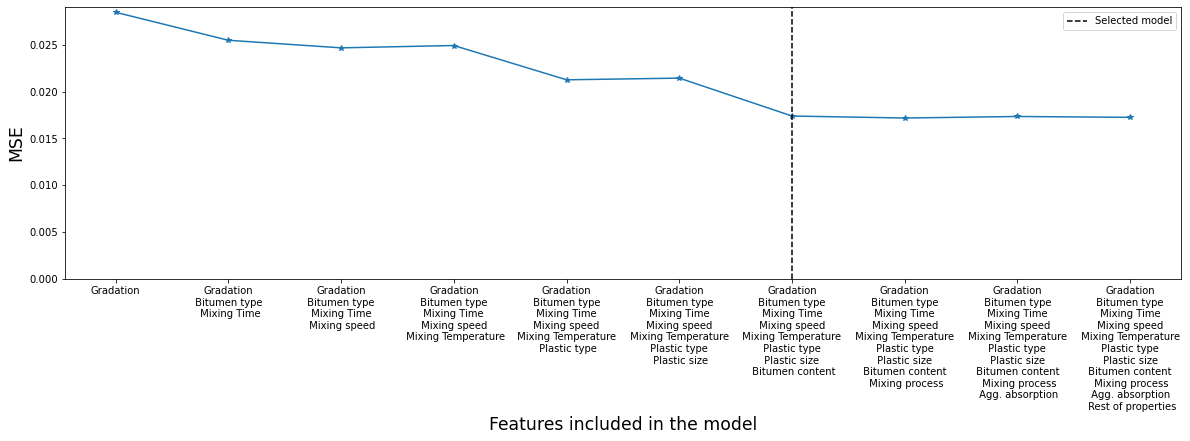

In [46]:
 plt.rcParams["figure.figsize"] = (20,5)
 plt.plot(features_MSE.keys(), features_MSE.values(), marker = '*') 
 plt.ylim(ymin = 0)
 plt.axvline(x='Gradation\n Bitumen type \n Mixing Time \n Mixing speed \n Mixing Temperature \n Plastic type \n Plastic size \n Bitumen content', ymin=0, ymax=1, color = 'k', ls = '--' , label='Selected model')
 plt.ylabel('MSE', fontsize = 'xx-large')
 plt.xlabel('Features included in the model', fontsize = 'xx-large')
 plt.legend()
 plt.show()

The features most approppiate for the model are aggregates gradation, bitumen content, plastic type, plastic addition, mixing type, and mixing parameters.
### 6.2 Model Tunning

In [30]:
def tuning_evaluation (parameters, X, y):
    param_grid = parameters
    grid = GridSearchCV(XGBRegressor(random_state = 1), param_grid, cv=cv, scoring=['neg_mean_squared_error', 'r2'], refit='neg_mean_squared_error')
    grid.fit(X, y)
    test_MSE = -grid.cv_results_['mean_test_neg_mean_squared_error'][grid.best_index_]
    test_r2 = grid.cv_results_['mean_test_r2'][grid.best_index_]
    best_param = grid.best_params_
    print ('r2 test: ' + str(test_r2))
    print ('MSE test: ' + str(test_MSE))
    print ('Best Parameters ' + str(best_param))

In [17]:
X_train = X_train[['0.075', '0.3', '0.6', '2.36', '4.75','9.5', '12.5', '19',
                    'Consolidated bitumen penetration grade_50/70', 'Consolidated bitumen penetration grade_70/100', 
                    'Mixing Time (hours)', 
                    'Mixing speed (RPM)',
                    'Mixing Temperature',
                    'New Plastic Type_Nylon',
                    'New Plastic Type_PE', 'New Plastic Type_PET', 'New Plastic Type_PP',
                    'New Plastic Type_PS', 'New Plastic Type_PU', 'New Plastic Type_PVC',
                    'New Plastic Type_Plastic Mix', 'New Plastic Type_e-waste',
                    'Plastic particle size (mm)',
                    'Bitumen content in the sample']]
X_test = X_test[['0.075', '0.3', '0.6', '2.36', '4.75','9.5', '12.5', '19',
                'Consolidated bitumen penetration grade_50/70', 'Consolidated bitumen penetration grade_70/100', 
                'Mixing Time (hours)', 
                'Mixing speed (RPM)',
                'Mixing Temperature',
                'New Plastic Type_Nylon',
                'New Plastic Type_PE', 'New Plastic Type_PET', 'New Plastic Type_PP',
                'New Plastic Type_PS', 'New Plastic Type_PU', 'New Plastic Type_PVC',
                'New Plastic Type_Plastic Mix', 'New Plastic Type_e-waste',
                'Plastic particle size (mm)',
                'Bitumen content in the sample']]

In [77]:
param_grid = {
        'eta':[0.1, 0.2, 0.3, 0.4, 0.5]
    }
tuning_evaluation (param_grid, X_train, y_train)

r2 test: 0.765461078759412
MSE test: 0.004032505043324879
Best Parameters {'eta': 0.4}


In [78]:
param_grid = {
        'eta':[0.4],
        'max_depth':np.arange(3,11,1)
    }
tuning_evaluation (param_grid, X_train, y_train)

r2 test: 0.7923656100169801
MSE test: 0.0035215619364103476
Best Parameters {'eta': 0.4, 'max_depth': 3}


In [79]:
param_grid = {
        'eta':[0.4],
        'max_depth':[3],
        'min_child_weight':np.arange(1,11,1)
    }
tuning_evaluation (param_grid, X = X_train, y = y_train)

r2 test: 0.7980422978161488
MSE test: 0.003255971110289621
Best Parameters {'eta': 0.4, 'max_depth': 3, 'min_child_weight': 3}


In [80]:
param_grid = {
        'eta':[0.4],
        'max_depth':[3],
        'min_child_weight':[3],
        'max_delta_step': np.arange(0,11,1)
    }
tuning_evaluation (param_grid, X = X_train, y = y_train)

r2 test: 0.7980422978161488
MSE test: 0.003255971110289621
Best Parameters {'eta': 0.4, 'max_delta_step': 0, 'max_depth': 3, 'min_child_weight': 3}


In [81]:
param_grid = {
        'eta':[0.4],
        'max_depth':[3],
        'min_child_weight':[3],
        'max_delta_step': [0],
        'gamma' : [0, 0.001, 0.01, 0.1, 1, 10]
    }
tuning_evaluation (param_grid, X = X_train, y = y_train)

r2 test: 0.7980422978161488
MSE test: 0.003255971110289621
Best Parameters {'eta': 0.4, 'gamma': 0, 'max_delta_step': 0, 'max_depth': 3, 'min_child_weight': 3}


In [83]:
param_grid = {
        'eta':[0.4],
        'max_depth':[3],
        'min_child_weight':[3],
        'max_delta_step': [0],
        'gamma' : [0],
        'subsample' : np.arange(0.5, 1.0, 0.1)
    }
tuning_evaluation (param_grid, X = X_train, y = y_train)

r2 test: 0.7976145923711605
MSE test: 0.003200912107323286
Best Parameters {'eta': 0.4, 'gamma': 0, 'max_delta_step': 0, 'max_depth': 3, 'min_child_weight': 3, 'subsample': 0.8999999999999999}


In [84]:
param_grid = {
        'eta':[0.4],
        'max_depth':[3],
        'min_child_weight':[3],
        'max_delta_step': [0],
        'gamma' : [0],
        'subsample' : [1],
        'colsample_bytree':[0, 0.5 ,1],
        'colsample_bylevel':[0, 0.5 ,1],
        'colsample_bynode':[0, 0.5 ,1]
    }
tuning_evaluation (param_grid, X = X_train, y = y_train)

r2 test: 0.813525434245568
MSE test: 0.002976406213328869
Best Parameters {'colsample_bylevel': 0.5, 'colsample_bynode': 1, 'colsample_bytree': 1, 'eta': 0.4, 'gamma': 0, 'max_delta_step': 0, 'max_depth': 3, 'min_child_weight': 3, 'subsample': 1}


In [87]:
param_grid = {
        'eta':[0.4],
        'max_depth':[3],
        'min_child_weight':[3],
        'max_delta_step': [0],
        'gamma' : [0],
        'subsample' : [1],
        'colsample_bytree':[1],
        'colsample_bylevel':[0.5],
        'colsample_bynode':[1],
        'lambda' : np.arange(1,10,1)
    }
tuning_evaluation (param_grid, X = X_train, y = y_train)

r2 test: 0.813525434245568
MSE test: 0.002976406213328869
Best Parameters {'colsample_bylevel': 0.5, 'colsample_bynode': 1, 'colsample_bytree': 1, 'eta': 0.4, 'gamma': 0, 'lambda': 1, 'max_delta_step': 0, 'max_depth': 3, 'min_child_weight': 3, 'subsample': 1}


In [32]:
param_grid = {
        'eta':[0.4],
        'max_depth':[3],
        'min_child_weight':[3],
        'max_delta_step': [0],
        'gamma' : [0],
        'subsample' : [1],
        'colsample_bytree':[1],
        'colsample_bylevel':[0.5],
        'colsample_bynode':[1],
        'lambda' : [1],
        'alpha' : np.arange(0,11,1)
    }
tuning_evaluation (param_grid, X = X_train, y = y_train)

r2 test: 0.6328001591688547
MSE test: 0.015990226039034546
Best Parameters {'alpha': 0, 'colsample_bylevel': 0.5, 'colsample_bynode': 1, 'colsample_bytree': 1, 'eta': 0.4, 'gamma': 0, 'lambda': 1, 'max_delta_step': 0, 'max_depth': 3, 'min_child_weight': 3, 'subsample': 1}


### 6.3 Final model evaluation on test set

In [18]:
XGModel = XGBRegressor()
XGModel.fit(X_train, y_train)
predictions_test = XGModel.predict(X_test)
r2_test = r2_score(y_test, predictions_test)
mse_test = mean_squared_error(y_test, predictions_test)
print('The test r2 is: ' + str(r2_test))
print('The test MSE is: ' + str(mse_test))
predictions_train = XGModel.predict(X_train)
r2_train = r2_score(y_train, predictions_train)
mse_train = mean_squared_error(y_train, predictions_train)
print('The train r2 is: ' + str(r2_train))
print('The train MSE is: ' + str(mse_train))

The test r2 is: 0.6293641973362438
The test MSE is: 0.011740716545470785
The train r2 is: 0.9960741051502929
The train MSE is: 0.00018080113956042712


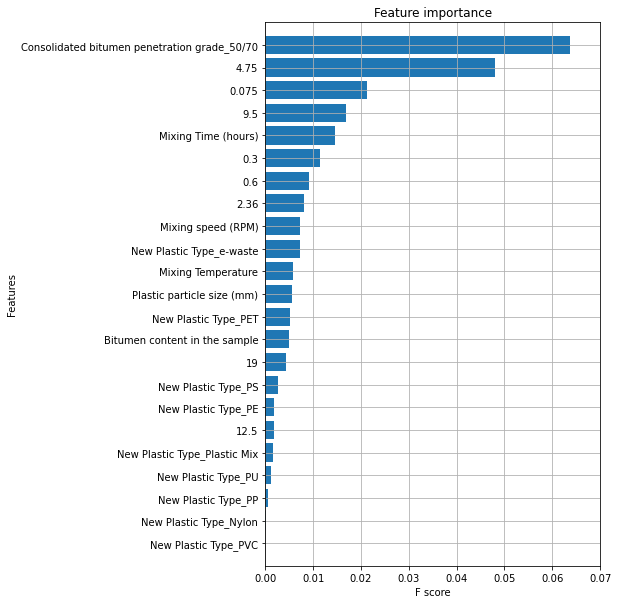

In [19]:
ax = xgb.plot_importance(XGModel, height=0.8, importance_type = 'gain', show_values = False)
fig = ax.figure
fig.set_size_inches(6,10)

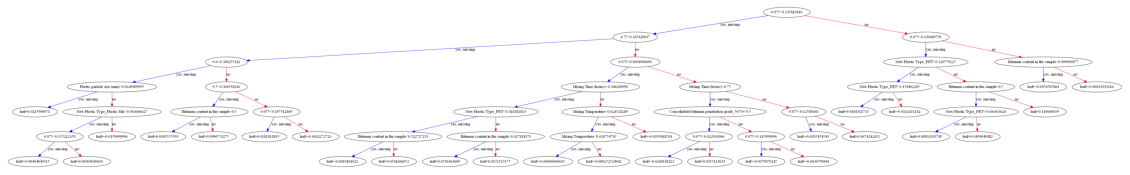

In [50]:
ax = xgb.plot_tree(XGModel)
fig = ax.figure
fig.set_size_inches(20,20)